In [40]:
# коллабные импорты
from google.colab import drive
from google.colab import files

In [41]:
!mkdir GD

mkdir: cannot create directory ‘GD’: File exists


In [42]:
drive.mount('/GD',force_remount=True)

Mounted at /GD


In [43]:
!cp -r /GD/'My Drive'/Semenov.zip .

In [44]:
!unzip Semenov.zip

Archive:  Semenov.zip
replace annotation/pic_0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
files.upload()

Saving Annotated_faces.csv to Annotated_faces.csv


{'Annotated_faces.csv': b'filename,width,height,clas,xmin,ymin,xmax,ymax\npic_0.jpg,640,480,sergey,254,116,449,352\npic_1.jpg,640,480,sergey,252,122,447,347\npic_10.jpg,640,480,sergey,250,143,445,308\npic_10.jpg,640,480,sergey,263,104,436,331\npic_11.jpg,640,480,sergey,256,129,428,323\npic_11.jpg,640,480,sergey,276,102,398,340\npic_11.jpg,640,480,sergey,245,155,447,306\npic_12.jpg,640,480,sergey,275,104,416,345\npic_12.jpg,640,480,sergey,244,158,445,312\npic_12.jpg,640,480,sergey,255,129,434,332\npic_13.jpg,640,480,sergey,257,130,428,336\npic_13.jpg,640,480,sergey,243,159,441,314\npic_13.jpg,640,480,sergey,277,112,412,344\npic_14.jpg,640,480,sergey,256,118,433,339\npic_15.jpg,640,480,sergey,246,115,433,335\npic_16.jpg,640,480,sergey,248,108,436,338\npic_17.jpg,640,480,sergey,254,114,435,350\npic_18.jpg,640,480,sergey,248,116,434,349\npic_19.jpg,640,480,sergey,246,105,436,350\npic_2.jpg,640,480,sergey,249,99,443,365\npic_20.jpg,640,480,sergey,239,108,433,336\npic_21.jpg,640,480,sergey,2

In [45]:
!ls

Annotated_faces.csv  GD    sample_data	xml_to_csv.py
annotation	     pics  Semenov.zip


In [ ]:
!unzip Semenov.zip

In [46]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import os
import pandas as pd
import math
import numpy as np
import sys
import matplotlib.pyplot as plt

import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

# Дебаты про выбор размера картинки для подачи на вход нейросети

Y = 480
X = 640

In [47]:
# Загружаем датафрэйм с разметкой
# имена файлов-картинок в список
df = pd.read_csv('Annotated_faces.csv')

In [ ]:
# Пишем функцию восстановления маски по имени файла
dff = df[df.filename == 'pic_99.jpg']

In [ ]:
dff

,filename,width,height,clas,xmin,ymin,xmax,ymax
248,pic_99.jpg,640,480,sergey,286,96,367,363
249,pic_99.jpg,640,480,sergey,254,111,392,341
250,pic_99.jpg,640,480,sergey,235,146,428,310


In [ ]:
ms = np.zeros((Y,X))

In [ ]:
ms[dff.iloc[0].ymin:dff.iloc[0].ymax,  dff.iloc[0].xmin:dff.iloc[0].xmax] = 1 
ms[dff.iloc[1].ymin:dff.iloc[1].ymax,  dff.iloc[1].xmin:dff.iloc[1].xmax] = 1 
ms[dff.iloc[2].ymin:dff.iloc[2].ymax,  dff.iloc[2].xmin:dff.iloc[2].xmax] = 1 

In [48]:
def get_mask_from_file(filename):
  
    dff = df[df.filename == filename]
    ms = np.zeros((Y,X,1))
    
    for i in range(dff.shape[0]):
        ms[dff.iloc[i].ymin:dff.iloc[i].ymax,  dff.iloc[i].xmin:dff.iloc[i].xmax] = 1

    return ms    



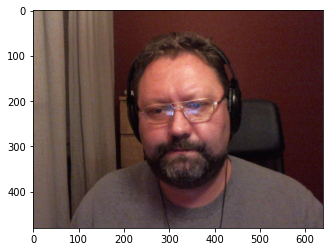

In [55]:
plt.imshow(im)

In [61]:
# формируем два массива - картинок и масок
img = []
msk = []

In [50]:
import os
filenames = os.listdir('pics')

In [51]:
Anno_filenames = df.filename.tolist()

In [62]:
for filename in filenames:
    
    
    im = image.load_img('pics/'+filename)
    im = image.img_to_array(im)
    
    if filename in Anno_filenames:
        ms = get_mask_from_file(filename)
    else:
        ms = np.zeros((Y,X,1)) 
        
    img.append(im)
    msk.append(ms)       


In [63]:
img = np.array(img)

In [66]:
msk.shape

(151, 480, 640, 1)

In [65]:
msk = np.array(msk)

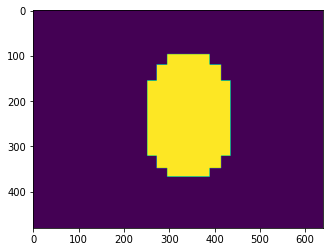

In [69]:
plt.imshow(msk[6].reshape((480,640)))

In [53]:
im = image.load_img('pics/pic_99.jpg')

In [ ]:
len(Anno_filenames), len(filenames)

(251, 151)

In [75]:
# Определяем метрику и функцию потерь

def IoU(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1.0)



In [76]:
# Unet
inputs = Input(shape = (Y, X, 3))

conv1_1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
conv1_2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv1_1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1_2)

conv2_1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv2_1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2_2)

conv3_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3_1)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3_2)

conv4_1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
conv4_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4_1)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4_2)


up1 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(pool4)
conc_1 = layers.Concatenate()([conv4_2, up1])
conv_up_1_1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conc_1)
conv_up_1_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv_up_1_1)

up2 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_up_1_2)
conc_2 = layers.Concatenate()([conv3_2, up2])
conv_up_2_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conc_2)
conv_up_2_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv_up_2_1)

up3 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_up_2_2)
conc_3 = layers.Concatenate()([conv2_2, up3])
conv_up_3_1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conc_3)
conv_up_3_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv_up_3_1)

up4 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_up_3_2)
conc_4 = layers.Concatenate()([conv1_2, up4])
conv_up_4_1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conc_4)
conv_up_4_2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv_up_4_1)

result = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv_up_4_2)

model = models.Model(inputs=inputs, outputs=result)

model.compile(loss = 'binary_crossentropy',
             optimizer=optimizers.Adam(lr=1e-3), metrics = [IoU])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [72]:
img = img / 255

In [73]:
data_gen_args = dict(rotation_range=10,
                    width_shift_range=0.15,
                    height_shift_range=0.15,
                    shear_range=0.15,
                    zoom_range=0.1,
                    horizontal_flip=False,
                    fill_mode='nearest')


image_datagen = ImageDataGenerator(**data_gen_args) #rescale = 1./255, **data_gen_args

mask_datagen = ImageDataGenerator(**data_gen_args)


seed = 1

                
image_generator = image_datagen.flow(img,  batch_size = 16,
                                                   seed = seed)

mask_generator = mask_datagen.flow(msk, batch_size = 16,
                                                   seed = seed)
                                                                                                  
train_generator = zip(image_generator, mask_generator)

In [77]:
from tensorflow.keras.callbacks import  ModelCheckpoint

filepath = "Face_net.h5"
chp = ModelCheckpoint(filepath, monitor = 'IoU', verbose = 1, save_best_only = True, mode = 'max')

In [79]:
history = model.fit_generator(train_generator,
                         steps_per_epoch = 151//16,
                         epochs = 20,
                         callbacks=[chp])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 0.1561 - IoU: 0.4018
Epoch 1: IoU improved from 0.28294 to 0.40179, saving model to Face_net.h5
9/9 [==============================] - 12s 1s/step - loss: 0.1561 - IoU: 0.4018
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 0.2734 - IoU: 0.2895
Epoch 2: IoU did not improve from 0.40179
9/9 [==============================] - 12s 1s/step - loss: 0.2734 - IoU: 0.2895
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 0.1551 - IoU: 0.4270
Epoch 3: IoU improved from 0.40179 to 0.42695, saving model to Face_net.h5
9/9 [==============================] - 12s 1s/step - loss: 0.1551 - IoU: 0.4270
Epoch 4/20
9/9 [==============================] - ETA: 0s - loss: 0.1188 - IoU: 0.5421
Epoch 4: IoU improved from 0.42695 to 0.54212, saving model to Face_net.h5
9/9 [==============================] - 12s 1s/step - loss: 0.1188 - IoU: 0.5421
Epoch 5/20
9/9 [==============================] - ETA: 0s - loss:

In [88]:
pred = model.predict(img[90:91])

In [81]:
pred.shape

(1, 480, 640, 1)

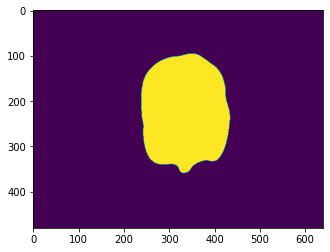

In [89]:
plt.imshow(pred.reshape((480,640))>0.5)

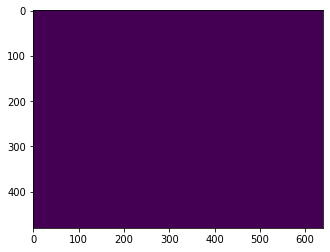

In [86]:
plt.imshow(msk[110].reshape((480,640)))

In [90]:
!cp Face_net.h5 /GD/'My Drive'/Face_net.h5

In [ ]:
# Совсем простецкий детектор - сверточная основа